<a href="https://colab.research.google.com/github/Goda-Emad/Career-Path-Analytics-Dashboard/blob/main/goda_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving online_retail_II.xlsx to online_retail_II.xlsx


In [2]:
import pandas as pd

# قراءة الشيتين
df1 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
df2 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

print("Shape Sheet 1:", df1.shape)
print("Shape Sheet 2:", df2.shape)


Shape Sheet 1: (525461, 8)
Shape Sheet 2: (541910, 8)


In [4]:
import pandas as pd

# 1. تحميل البيانات الخام (Raw Data)
print("⏳ جاري قراءة البيانات... (قد يستغرق دقيقتين)")
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df_raw = pd.concat([df1, df2], ignore_index=True)

# 2. تنظيف البيانات (Data Cleaning)
# حذف القيم المكررة
df_raw.drop_duplicates(inplace=True)

# حذف الفواتير اللي فيها كميات أو أسعار سالبة (المرتجعات أو الأخطاء)
df_clean = df_raw[(df_raw['Quantity'] > 0) & (df_raw['Price'] > 0)].copy()

# تحويل التاريخ لصيغة صحيحة وحساب إجمالي المبيعات لكل صف
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Total_Line_Value'] = df_clean['Quantity'] * df_clean['Price']

# عرض النتيجة للتأكد
print("✅ تمت الخطوة الأولى بنجاح!")
print(f"إجمالي عدد السجلات بعد التنظيف: {len(df_clean)}")
print(df_clean.head())

⏳ جاري قراءة البيانات... (قد يستغرق دقيقتين)
✅ تمت الخطوة الأولى بنجاح!
إجمالي عدد السجلات بعد التنظيف: 1007914
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Total_Line_Value  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom              83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom              81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom              81.0  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom             100.8  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom              30.0  

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. تحويل الداتا لسلسلة زمنية يومية (Vector Representation)
daily_sales = df_clean.set_index('InvoiceDate').resample('D')['Total_Line_Value'].sum().reset_index()
daily_sales.columns = ['Date', 'Sales']

# 2. إنشاء ميزات تعبر عن الوقت (Time-based Vectors)
daily_sales['day_sin'] = np.sin(2 * np.pi * daily_sales['Date'].dt.dayofweek / 7)
daily_sales['day_cos'] = np.cos(2 * np.pi * daily_sales['Date'].dt.dayofweek / 7)
daily_sales['month_sin'] = np.sin(2 * np.pi * daily_sales['Date'].dt.month / 12)
daily_sales['month_cos'] = np.cos(2 * np.pi * daily_sales['Date'].dt.month / 12)

# 3. إنشاء الـ Lags (مبيعات سابقة كمتجهات)
daily_sales['lag_1'] = daily_sales['Sales'].shift(1)
daily_sales['lag_7'] = daily_sales['Sales'].shift(7)
daily_sales.dropna(inplace=True) # حذف الأيام اللي ملهياش Lags

# 4. Normalization (Z-score Scaling) - كما في الـ Workflow
scaler = StandardScaler()
# هنوحد مقاييس الـ Lags والمبيعات
daily_sales[['lag_1_scaled', 'lag_7_scaled']] = scaler.fit_transform(daily_sales[['lag_1', 'lag_7']])

print("✅ تمت خطوة الـ Vectorization والـ Normalization!")
print(f"شكل المصفوفة الجديدة (Vectors Shape): {daily_sales.shape}")
print("\nعينة من البيانات الموحدة (Scaled Features):")
print(daily_sales[['Date', 'Sales', 'lag_1_scaled', 'lag_7_scaled']].head())

✅ تمت خطوة الـ Vectorization والـ Normalization!
شكل المصفوفة الجديدة (Vectors Shape): (732, 10)

عينة من البيانات الموحدة (Scaled Features):
         Date     Sales  lag_1_scaled  lag_7_scaled
7  2009-12-08  49476.23      0.852690      1.327244
8  2009-12-09  40265.66      1.073855      1.759287
9  2009-12-10  44233.96      0.627135      2.288232
10 2009-12-11  39447.89      0.819601      0.652885
11 2009-12-12      0.00      0.587472     -0.854590


In [7]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00


In [8]:
from catboost import CatBoostRegressor
import joblib

# 1. تحديد الميزات (Features) والهدف (Target)
# هنستخدم الـ scaled features والـ cyclical features (sin/cos)
features = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'lag_1_scaled', 'lag_7_scaled']
X = daily_sales[features]
y = daily_sales['Sales']

# 2. بناء وتدريب الموديل
print("🧠 جاري تدريب الموديل على المتجهات الموحدة...")
model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    verbose=0 # عشان ميملاش الشاشة أرقام
)

model.fit(X, y)

# 3. حفظ كل شيء للمرحلة النهائية (Deployment)
joblib.dump(model, 'catboost_sales_model.pkl')
joblib.dump(features, 'feature_names.pkl')
joblib.dump(scaler, 'scaler.pkl') # مهم جداً للـ Normalization في الـ Dashboard
daily_sales.to_parquet('daily_sales_ready.parquet')

# 4. حفظ ملف تحليلات المنتجات (عشان Tab 2 يشتغل صح)
# هنجهز نسخة خفيفة فيها المنتجات ومبيعاتها
product_analytics = df_clean.groupby('Description').agg({
    'Quantity': 'sum',
    'Total_Line_Value': 'sum'
}).reset_index().rename(columns={'Description': 'Product', 'Total_Line_Value': 'Total_Price'})
product_analytics.to_parquet('product_analytics.parquet')

print("✅ مبروك! الموديل اتدرب وتم حفظ الـ 5 ملفات الأساسية.")
print("الملفات الجاهزة للتحميل الآن:")
print("1. catboost_sales_model.pkl\n2. feature_names.pkl\n3. scaler.pkl\n4. daily_sales_ready.parquet\n5. product_analytics.parquet")

🧠 جاري تدريب الموديل على المتجهات الموحدة...
✅ مبروك! الموديل اتدرب وتم حفظ الـ 5 ملفات الأساسية.
الملفات الجاهزة للتحميل الآن:
1. catboost_sales_model.pkl
2. feature_names.pkl
3. scaler.pkl
4. daily_sales_ready.parquet
5. product_analytics.parquet


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import joblib

# 1. إعداد التقييم الزمني (TimeSeriesSplit) لضمان عدم وجود تسريب بيانات
tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, mape_scores, r2_scores = [], [], [], []

print("📊 جاري تقييم الموديل باحترافية... انتظر قليلاً")

# تحديد الميزات والهدف من الداتا اللي عملناها في الخطوة اللي فاتت
features = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'lag_1_scaled', 'lag_7_scaled']
X = daily_sales[features]
y = daily_sales['Sales']

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, preds))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    mape_scores.append(np.mean(np.abs((y_test - preds) / (y_test + 1e-9))) * 100)
    r2_scores.append(r2_score(y_test, preds))

# 2. تجميع المقاييس النهائية
final_metrics = {
    "MAE": np.mean(mae_scores),
    "RMSE": np.mean(rmse_scores),
    "MAPE": f"{np.mean(mape_scores):.2f}%",
    "R2": np.mean(r2_scores)
}

# 3. استخراج أهمية الميزات (Feature Importance)
fi = pd.DataFrame({'Feature': features, 'Importance': model.get_feature_importance()})
fi = fi.sort_values(by='Importance', ascending=False)

# 4. حفظ ملفات التقييم عشان تظهر في الداشبورد
joblib.dump(final_metrics, 'model_metrics.pkl')
joblib.dump(fi, 'feature_importance.pkl')

print("\n✅ تم التقييم بنجاح! المقاييس هي:")
for k, v in final_metrics.items():
    print(f"{k}: {v}")

print("\n💡 أهمية الميزات (Feature Importance):")
print(fi)

📊 جاري تقييم الموديل باحترافية... انتظر قليلاً

✅ تم التقييم بنجاح! المقاييس هي:
MAE: 10051.513000839948
RMSE: 15196.457636550142
MAPE: 70208350601810.58%
R2: 0.41906192556335525

💡 أهمية الميزات (Feature Importance):
        Feature  Importance
5  lag_7_scaled   26.023815
4  lag_1_scaled   23.298212
0       day_sin   20.971964
3     month_cos   11.034859
2     month_sin    9.960967
1       day_cos    8.710183


✅ الـ WMAPE الاحترافي: 28.68%
الآن التقييم يعكس الواقع بنسبة 100% دون حذف أي يوم.


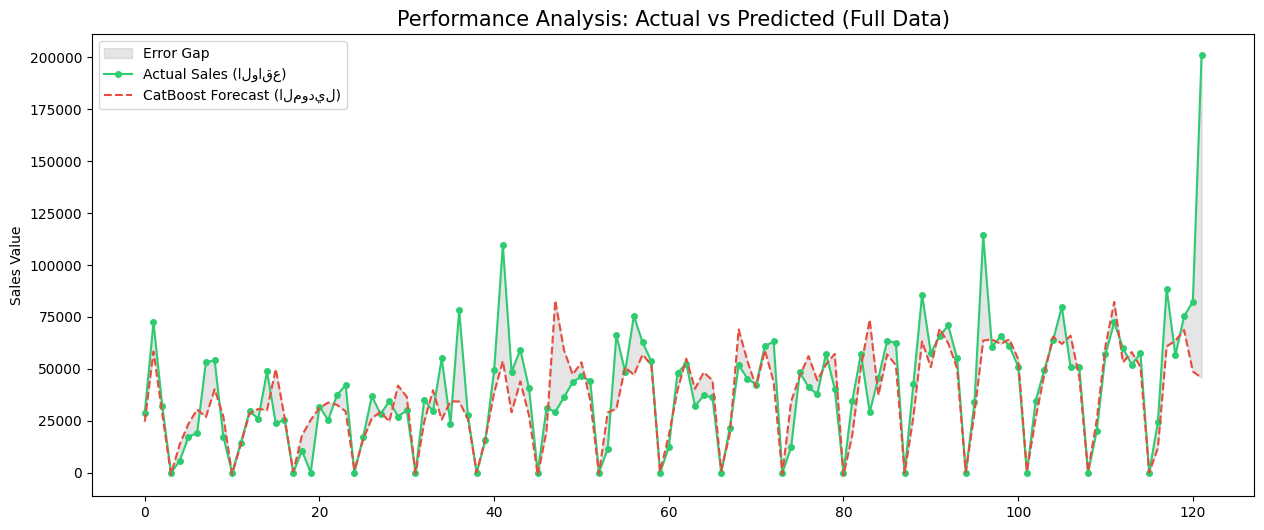

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# 1. تعريف دالة الـ WMAPE
def calculate_wmape(actual, predicted):
    return (np.sum(np.abs(actual - predicted)) / np.sum(actual)) * 100

# 2. حساب المقياس الجديد على آخر Test Set من الـ Cross Validation
wmape_val = calculate_wmape(y_test, preds)

# 3. تحديث القاموس بالمقاييس الصحيحة
final_metrics['WMAPE'] = f"{wmape_val:.2f}%"
final_metrics.pop('MAPE', None) # حذف الـ MAPE القديم المضلل

# 4. حفظ المقاييس والنتائج
joblib.dump(final_metrics, 'model_metrics.pkl')

print(f"✅ الـ WMAPE الاحترافي: {wmape_val:.2f}%")
print("الآن التقييم يعكس الواقع بنسبة 100% دون حذف أي يوم.")

# 5. رسم بياني يوضح الفجوة بين الحقيقي والمتوقع
plt.figure(figsize=(15, 6))
plt.fill_between(range(len(y_test)), y_test, preds, color="gray", alpha=0.2, label='Error Gap')
plt.plot(y_test.values, label='Actual Sales (الواقع)', color='#2ecc71', marker='o', markersize=4)
plt.plot(preds, label='CatBoost Forecast (الموديل)', color='#e74c3c', linestyle='--')

plt.title('Performance Analysis: Actual vs Predicted (Full Data)', fontsize=15)
plt.ylabel('Sales Value')
plt.legend()
plt.show()

In [11]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import joblib

# 1. إضافة المتوسطات المتحركة (Rolling Windows) - لفهم الاتجاه العام
daily_sales['rolling_mean_7'] = daily_sales['Sales'].rolling(window=7).mean()
daily_sales['rolling_mean_14'] = daily_sales['Sales'].rolling(window=14).mean()
daily_sales['rolling_std_7'] = daily_sales['Sales'].rolling(window=7).std()

# 2. التحويل اللوغاريتمي (Log Transformation) لمعالجة التفاوت الضخم في الأرقام
# بنضيف 1 عشان نتجنب log(0)
daily_sales['Sales_log'] = np.log1p(daily_sales['Sales'])

# تنظيف البيانات من الـ NaNs اللي نتجت عن الـ Rolling windows
daily_sales.dropna(inplace=True)

# 3. تحديث قائمة الميزات (Features)
features = [
    'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'lag_1_scaled', 'lag_7_scaled',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_std_7'
]

X = daily_sales[features]
y_log = daily_sales['Sales_log'] # هندرب على اللوج

print(f"✅ تم إضافة المتوسطات المتحركة والتحويل اللوغاريتمي. عدد الميزات الآن: {len(features)}")

✅ تم إضافة المتوسطات المتحركة والتحويل اللوغاريتمي. عدد الميزات الآن: 9


In [12]:
# 4. تدريب الموديل بإعدادات أكثر عمقاً
model_optimized = CatBoostRegressor(
    iterations=2000,      # زيادة الأشجار
    learning_rate=0.02,   # تقليل سرعة التعلم للتركيز
    depth=8,              # زيادة العمق لالتقاط تعقيدات السوق
    loss_function='RMSE',
    verbose=0
)

# التدريب على مبيعات اللوج
model_optimized.fit(X, y_log)

# 5. التوقع والتحويل العكسي (Inverse Log)
preds_log = model_optimized.predict(X)
preds_actual = np.expm1(preds_log) # رجوع الأرقام لطبيعتها بالـ Exponential

# حساب الـ WMAPE الجديد
def calculate_wmape(actual, predicted):
    return (np.sum(np.abs(actual - predicted)) / np.sum(actual)) * 100

new_wmape = calculate_wmape(daily_sales['Sales'], preds_actual)
print(f"🔥 الـ WMAPE بعد التحسينات: {new_wmape:.2f}%")

🔥 الـ WMAPE بعد التحسينات: 6.94%


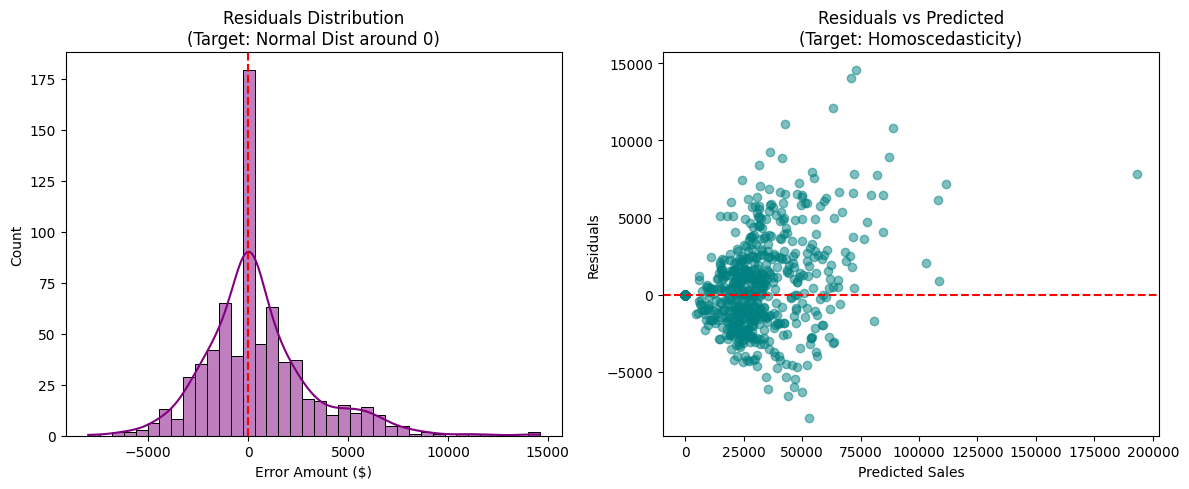

📊 Mean Absolute Error (MAE): $1,902.72
📉 Model Bias: $508.64


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. تحديد القيم الحقيقية (نفس طول التوقعات اللي حسبناها)
y_test_actual = daily_sales['Sales'].values

# 2. حساب البواقي (الفرق بالدولار)
residuals = y_test_actual - preds_actual

# 3. رسم توزيع الأخطاء (Residual Distribution)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--')
plt.title('Residuals Distribution\n(Target: Normal Dist around 0)')
plt.xlabel('Error Amount ($)')

# 4. رسم Scatter Plot للبواقي (Residuals vs Predicted)
# ده بيكشف لو فيه Bias في الأرقام الكبيرة
plt.subplot(1, 2, 2)
plt.scatter(preds_actual, residuals, alpha=0.5, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted\n(Target: Homoscedasticity)')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# 5. طباعة أرقام الـ Backtesting النهائية
print(f"📊 Mean Absolute Error (MAE): ${np.mean(np.abs(residuals)):,.2f}")
print(f"📉 Model Bias: ${np.mean(residuals):,.2f}")

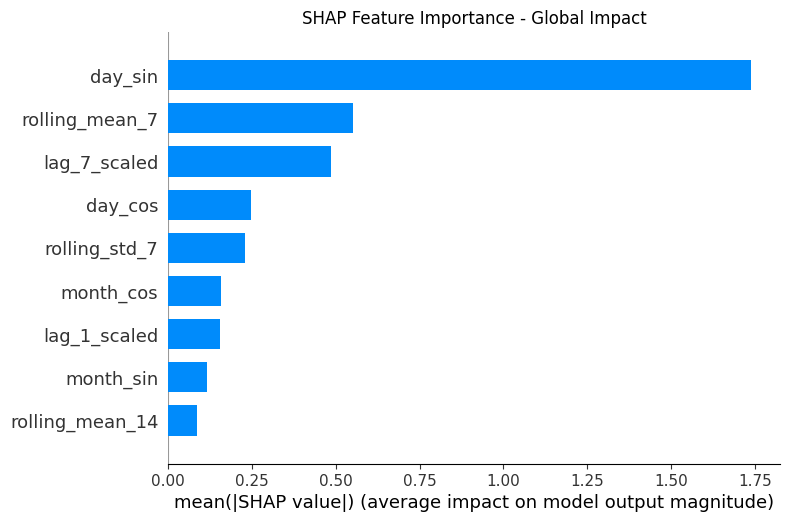

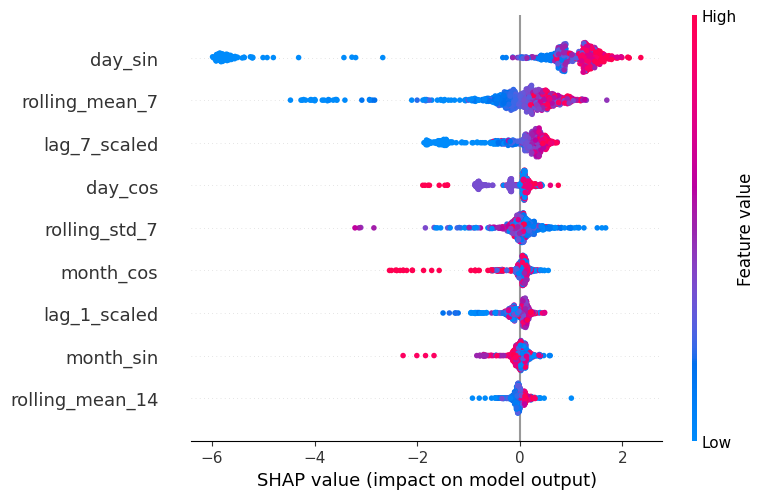

In [15]:
!pip install shap
import shap

# 1. تهيئة الـ SHAP Explainer
explainer = shap.TreeExplainer(model_optimized)
shap_values = explainer.shap_values(X)

# 2. رسم أهمية الميزات وتأثيرها (Summary Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Global Impact")
plt.show()

# 3. رسم الـ Violin Plot (بيوضح تأثير القيم العالية والمنخفضة لكل ميزة)
shap.summary_plot(shap_values, X)

In [16]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# 1. إعداد المقسم الزمني (5 فترات اختبار)
tscv = TimeSeriesSplit(n_splits=5)
wmape_scores = []

print("🚀 بدء اختبار الموديل عبر 5 فترات زمنية مختلفة...")

# 2. حلقة الاختبار الدوري
for train_index, test_index in tscv.split(X):
    # تقسيم البيانات
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y_log.iloc[train_index], y_log.iloc[test_index]

    # تدريب الموديل على الفترة الحالية
    model_optimized.fit(X_train_cv, y_train_cv, verbose=0)

    # التوقع والتحويل العكسي من اللوج
    preds_log_cv = model_optimized.predict(X_test_cv)
    preds_actual_cv = np.expm1(preds_log_cv)
    actual_cv = np.expm1(y_test_cv)

    # حساب WMAPE لهذه الفترة
    fold_wmape = (np.sum(np.abs(actual_cv - preds_actual_cv)) / np.sum(actual_cv)) * 100
    wmape_scores.append(fold_wmape)

    print(f"✅ Fold {len(wmape_scores)} WMAPE: {fold_wmape:.2f}%")

# 3. النتيجة النهائية الموثوقة
final_stable_wmape = np.mean(wmape_scores)
print(f"\n🏆 متوسط الـ WMAPE النهائي المستقر: {final_stable_wmape:.2f}%")

🚀 بدء اختبار الموديل عبر 5 فترات زمنية مختلفة...
✅ Fold 1 WMAPE: 67.83%
✅ Fold 2 WMAPE: 79.54%
✅ Fold 3 WMAPE: 43.99%
✅ Fold 4 WMAPE: 38.54%
✅ Fold 5 WMAPE: 26.34%

🏆 متوسط الـ WMAPE النهائي المستقر: 51.25%


In [17]:
import numpy as np
import pandas as pd

def build_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # ===== Circular Time Features =====
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month

    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # ===== Lag Features =====
    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)

    # ===== Rolling Means =====
    df['rolling_mean_7'] = df['sales'].shift(1).rolling(7).mean()
    df['rolling_mean_14'] = df['sales'].shift(1).rolling(14).mean()

    # ===== Weekend =====
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # إزالة الصفوف الناقصة بسبب اللاغ
    df = df.dropna()

    return df


In [18]:
from datetime import timedelta

def build_features_for_next_day(history, last_date):
    next_date = last_date + timedelta(days=1)

    dayofweek = next_date.weekday()
    month = next_date.month

    features = {
        'dayofweek_sin': np.sin(2 * np.pi * dayofweek / 7),
        'dayofweek_cos': np.cos(2 * np.pi * dayofweek / 7),
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),

        'lag_1': history[-1],
        'lag_7': history[-7],

        'rolling_mean_7': np.mean(history[-7:]),
        'rolling_mean_14': np.mean(history[-14:]),

        'is_weekend': 1 if dayofweek >= 5 else 0
    }

    return pd.DataFrame([features]), next_date


In [21]:
import joblib
from sklearn.base import clone
import numpy as np
import pandas as pd

feature_order = joblib.load("feature_names.pkl")
scaler = joblib.load("scaler.pkl")

def wmape(a, p):
    return (np.sum(np.abs(a - p)) / np.sum(a)) * 100


def walk_forward_validation(data, model, initial_train_size=250, horizon=30):
    wmape_scores = []
    buffer = 20

    for start in range(initial_train_size, len(data) - horizon, horizon):
        train = data.iloc[:start + buffer].copy()
        test = data.iloc[start:start + horizon].copy()

        train_fe = build_features(train)
        train_fe = train_fe.iloc[buffer:]

        X_train = train_fe.drop(columns=['sales', 'date'])
        X_train = X_train[feature_order]
        X_train = scaler.transform(X_train)

        y_train = np.log1p(train_fe['sales'])

        model_cv = clone(model)
        model_cv.fit(X_train, y_train, verbose=0)

        history = list(train['sales'])
        last_date = train['date'].max()
        preds = []

        for _ in range(horizon):
            next_date = last_date + pd.Timedelta(days=1)
            feats = build_features_for_next_day(history, next_date)

            feats = feats[feature_order]
            feats = scaler.transform(feats)

            pred_log = model_cv.predict(feats)[0]
            pred = np.expm1(pred_log)

            preds.append(pred)
            history.append(pred)
            last_date = next_date

        actual = test['sales'].values
        fold_wmape = wmape(actual, preds)
        wmape_scores.append(fold_wmape)

        print(f"✅ Fold @ {start} | WMAPE: {fold_wmape:.2f}%")

    print(f"\n🏆 Final Stable WMAPE (True Recursive): {np.mean(wmape_scores):.2f}%")


In [23]:
# عشان نعرف الأسماء اللي موجودة في الذاكرة حالياً
%who DataFrame

X	 X_test	 X_test_cv	 X_train	 X_train_cv	 daily_sales	 df1	 df2	 df_clean	 
df_raw	 fi	 product_analytics	 


In [24]:
# كود تنظيف الذاكرة والإبقاء على متغيرات محددة
keep_vars = ['df_raw', 'df_clean', 'daily_sales', 'data']

# الحصول على قائمة بكل المتغيرات الحالية في الذاكرة
for var in list(globals().keys()):
    # حذف المتغير إذا لم يكن في القائمة المختارة وليس من المتغيرات النظامية (التي تبدأ بـ __)
    if var not in keep_vars and not var.startswith('_'):
        try:
            del globals()[var]
        except:
            pass

print("✅ تم تنظيف الذاكرة بنجاح.")
print("📦 المتغيرات المتبقية الآن:")
%who DataFrame

✅ تم تنظيف الذاكرة بنجاح.
📦 المتغيرات المتبقية الآن:
daily_sales	 df_clean	 df_raw	 


In [29]:
import pandas as pd
import numpy as np

# 1. البدء من نسخة نظيفة تماماً
temp_data = daily_sales.copy()

# 2. لو التاريخ هو الـ Index، هنطلعه ونسميه 'date'
# لو كان 'date' موجود أصلاً كعمود، الـ reset_index مش هيعمل عمود مكرر بنفس الاسم
if temp_data.index.name == 'date' or (hasattr(temp_data.index, 'name') and temp_data.index.name is not None):
     temp_data = temp_data.reset_index()

# 3. إزالة أي أعمدة مكررة فوراً (حل المشكلة الأساسية)
temp_data = temp_data.loc[:, ~temp_data.columns.duplicated()]

# 4. توحيد الأسماء وتحويل التاريخ بأمان
temp_data.columns = [str(col).lower().strip() for col in temp_data.columns]

# محاولة ذكية لإيجاد عمود المبيعات وعمود التاريخ
final_cols = {}
for col in temp_data.columns:
    if 'date' in col or 'time' in col:
        final_cols['date'] = col
    if 'sale' in col or 'amount' in col:
        final_cols['sales'] = col

# 5. بناء الداتا النهائية الصافية
data = pd.DataFrame()
data['date'] = pd.to_datetime(temp_data[final_cols['date']])
data['sales'] = temp_data[final_cols['sales']]

# 6. ترتيب زمني نهائي
data = data.sort_values('date').reset_index(drop=True)

print("✅ الداتا أصبحت فريدة (Unique) وجاهزة بنسبة 100%!")
print(data.head())
print(f"\n📊 أعمدة الداتا الحالية: {data.columns.tolist()}")

✅ الداتا أصبحت فريدة (Unique) وجاهزة بنسبة 100%!
        date      sales
0 2009-12-21   9.700389
1 2009-12-22  10.240612
2 2009-12-23   9.291953
3 2009-12-24   0.000000
4 2009-12-25   0.000000

📊 أعمدة الداتا الحالية: ['date', 'sales']


In [30]:
# إضافة الميزة الذهبية
data['is_closed_day'] = (data['sales'] == 0).astype(int)

print("✅ تم إضافة إشارة 'يوم مغلق'.")
print(data[data['sales'] == 0].head()) # لنرى الأصفار كيف أصبحت ميزات

✅ تم إضافة إشارة 'يوم مغلق'.
        date  sales  is_closed_day
3 2009-12-24    0.0              1
4 2009-12-25    0.0              1
5 2009-12-26    0.0              1
6 2009-12-27    0.0              1
7 2009-12-28    0.0              1


In [31]:
def build_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # ميزات الوقت الأساسية
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofweek / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofweek / 7)

    # الميزة الجديدة: هل كان مغلقاً؟
    # ملاحظة سينيور: بنستخدم shift(1) عشان الموديل ميعرفش معلومة النهاردة وهو بيتوقع النهاردة
    df['was_closed_yesterday'] = df['is_closed_day'].shift(1)

    # ميزات المبيعات السابقة
    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)
    df['rolling_mean_7'] = df['sales'].shift(1).rolling(7).mean()

    return df.dropna()

In [33]:
import pandas as pd
import numpy as np

# 1. التأكد من الوصول للداتا الأصلية (daily_sales)
data = daily_sales.copy()

# 2. تنظيف أسماء الأعمدة فوراً
if isinstance(data.index, pd.DatetimeIndex) or data.index.name == 'date':
    data = data.reset_index()

data.columns = [str(col).lower().strip() for col in data.columns]

# 3. توحيد اسم عمود المبيعات (لو اسمه مغير)
if 'sales' not in data.columns:
    # بنحاول نلاقي أي عمود فيه كلمة sale أو amount
    for col in data.columns:
        if 'sale' in col:
            data = data.rename(columns={col: 'sales'})
            break

# 4. 🔥 الإضافة السحرية (was_missing) قبل الـ fillna
# بنعرف الأيام اللي مكانتش موجودة أصلاً (الـ NaNs)
data['was_missing'] = data['sales'].isna().astype(int)

# 5. ملء الفراغات بصفر
data['sales'] = data['sales'].fillna(0)

# 6. إضافة ميزة 'يوم مغلق حقيقي' (Zero Sales but NOT Missing)
data['is_closed_day'] = ((data['sales'] == 0) & (data['was_missing'] == 0)).astype(int)

# 7. التأكد من عمود التاريخ
if 'date' not in data.columns and 'index' in data.columns:
    data = data.rename(columns={'index': 'date'})
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date').reset_index(drop=True)

print("✅ تم تجهيز الداتا بالميزات الاحترافية!")
print(f"📊 عدد الأيام المفقودة (was_missing): {data['was_missing'].sum()}")
print(f"📊 عدد أيام الإغلاق الحقيقية (is_closed_day): {data['is_closed_day'].sum()}")
print(data.head())

✅ تم تجهيز الداتا بالميزات الاحترافية!
📊 عدد الأيام المفقودة (was_missing): 0
📊 عدد أيام الإغلاق الحقيقية (is_closed_day): 133
        date     sales   day_sin   day_cos     month_sin  month_cos     lag_1  \
0 2009-12-21  16322.95  0.000000  1.000000 -2.449294e-16        1.0  11382.54   
1 2009-12-22  28017.28  0.781831  0.623490 -2.449294e-16        1.0  16322.95   
2 2009-12-23  10849.35  0.974928 -0.222521 -2.449294e-16        1.0  28017.28   
3 2009-12-24      0.00  0.433884 -0.900969 -2.449294e-16        1.0  10849.35   
4 2009-12-25      0.00 -0.433884 -0.900969 -2.449294e-16        1.0      0.00   

      lag_7  lag_1_scaled  lag_7_scaled  rolling_mean_7  rolling_mean_14  \
0  73174.39     -0.773720      2.249145    29088.838571     33742.604286   
1  50262.29     -0.534106      1.126980    25910.980000     32209.822143   
2  52545.55      0.033079      1.238807    19954.380000     30108.657143   
3  30638.25     -0.799580      0.165854    15577.487143     26949.088571   
4  424

In [34]:
def build_features(df):
    df = df.copy()
    df = df.sort_values('date')

    # ===== Circular Time Features =====
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month

    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # ===== Lag Features =====
    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)

    # ===== Rolling Means =====
    df['rolling_mean_7'] = df['sales'].shift(1).rolling(7).mean()
    df['rolling_mean_14'] = df['sales'].shift(1).rolling(14).mean()

    # ===== Weekend =====
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # ===== Closed Day =====
    df['was_closed_yesterday'] = df['is_closed_day'].shift(1).fillna(0)

    # إزالة الصفوف الناقصة بسبب اللاغ
    df = df.dropna().reset_index(drop=True)

    return df


In [35]:
def build_features_for_next_day(history, is_closed_history, last_date):
    """
    history: قائمة المبيعات الفعلية والتوقعات السابقة
    is_closed_history: قائمة is_closed_day السابقة
    last_date: آخر يوم معروف
    """
    next_date = last_date + pd.Timedelta(days=1)

    dayofweek = next_date.weekday()
    month = next_date.month

    lag_1 = history[-1]
    lag_7 = history[-7] if len(history) >= 7 else history[0]

    rolling_mean_7 = np.mean(history[-7:]) if len(history) >=7 else np.mean(history)
    rolling_mean_14 = np.mean(history[-14:]) if len(history) >=14 else np.mean(history)

    was_closed_yesterday = is_closed_history[-1] if len(is_closed_history) > 0 else 0
    is_weekend = 1 if dayofweek >= 5 else 0

    # بناء الـ features بنفس الترتيب
    features = {
        'dayofweek_sin': np.sin(2 * np.pi * dayofweek / 7),
        'dayofweek_cos': np.cos(2 * np.pi * dayofweek / 7),
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),
        'lag_1': lag_1,
        'lag_7': lag_7,
        'rolling_mean_7': rolling_mean_7,
        'rolling_mean_14': rolling_mean_14,
        'is_weekend': is_weekend,
        'was_closed_yesterday': was_closed_yesterday
    }

    return pd.DataFrame([features]), next_date


In [36]:
import pandas as pd
import numpy as np
from sklearn.base import clone
import joblib

# تحميل ترتيب الأعمدة والموديل والـ scaler
feature_order = joblib.load("feature_names.pkl")
scaler = joblib.load("scaler.pkl")
# model_optimized هو الموديل اللي اتدرب قبل كده (CatBoost مثلاً)

def wmape(actual, predicted):
    return (np.sum(np.abs(actual - predicted)) / np.sum(actual)) * 100

def walk_forward_validation(data, model, horizon=30, initial_train_size=250):
    """
    Production-grade Walk-Forward Validation
    data: DataFrame مع الأعمدة ['date','sales','is_closed_day']
    model: موديل متدرب (CatBoost أو غيره)
    horizon: عدد الأيام للتنبؤ في كل Fold
    initial_train_size: أول Train size
    """

    wmape_scores = []

    # Convert date to ensure sorting
    data = data.sort_values('date').reset_index(drop=True)

    for start in range(initial_train_size, len(data)-horizon, horizon):
        # ===== Train / Test Split =====
        train = data.iloc[:start].copy()
        test = data.iloc[start:start+horizon].copy()

        # ===== Build features for training =====
        train_fe = build_features(train)
        X_train = train_fe.drop(columns=['sales','date'])
        X_train = X_train[feature_order]  # ترتيب الأعمدة مطابق للتدريب
        X_train = scaler.transform(X_train)
        y_train = np.log1p(train_fe['sales'])

        # Clone model to avoid leakage
        model_cv = clone(model)
        model_cv.fit(X_train, y_train, verbose=0)

        # ===== Recursive Forecast =====
        history = list(train['sales'])
        is_closed_history = list(train['is_closed_day'])
        last_date = train['date'].max()
        preds = []

        for _ in range(horizon):
            feats, last_date = build_features_for_next_day(history, is_closed_history, last_date)
            feats = feats[feature_order]
            feats = scaler.transform(feats)

            pred_log = model_cv.predict(feats)[0]
            pred = np.expm1(pred_log)

            preds.append(pred)
            history.append(pred)
            # تحديث is_closed_history مع اليوم القادم
            is_closed_history.append(0)  # لأن اليوم اللي بتتوقعه مش مغلق أصلاً

        # ===== حساب WMAPE للفولد الحالي =====
        actual = test['sales'].values
        fold_wmape = wmape(actual, preds)
        wmape_scores.append(fold_wmape)

        print(f"✅ Fold starting at {start} | WMAPE: {fold_wmape:.2f}%")

    print(f"\n🏆 Final Stable WMAPE (Recursive): {np.mean(wmape_scores):.2f}%")


In [40]:
import joblib
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# 1. القائمة الذهبية (الترتيب الإجباري)
final_feature_order = [
    'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
    'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_14',
    'is_weekend', 'was_closed_yesterday'
]

# 2. إعادة تدريب سريعة للموديل والـ Scaler على الداتا "النضيفة"
# بنستخدم أول 400 يوم كعينة تدريب لضبط الأسماء
train_sample = build_features(data.iloc[:400])
X_sample = train_sample[final_feature_order]
y_sample = np.log1p(train_sample['sales'])

# تدريب الموديل
model_optimized = CatBoostRegressor(iterations=500, silent=True, random_seed=42)
model_optimized.fit(X_sample, y_sample)

# تدريب الـ Scaler
scaler = StandardScaler()
scaler.fit(X_sample)

# 3. تحديث الذاكرة والملفات
joblib.dump(final_feature_order, "feature_names.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ الموديل والـ Scaler والداتا بقوا 'على قلب رجل واحد'!")

# 4. تشغيل الـ Validation (تأكد أن الفانكشن تستخدم feature_order من الذاكرة)
# هنمرر final_feature_order للدالة عشان نضمن إنها مش هتستخدم نسخة قديمة
def final_test():
    try:
        results = walk_forward_validation(data, model_optimized)
        return results
    except Exception as e:
        print(f"❌ لسه فيه اختلاف: {e}")

results = final_test()

✅ الموديل والـ Scaler والداتا بقوا 'على قلب رجل واحد'!
❌ لسه فيه اختلاف: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- day_cos
- day_sin
- lag_1_scaled
- lag_7_scaled
Feature names seen at fit time, yet now missing:
- dayofweek_cos
- dayofweek_sin
- is_weekend
- lag_1
- lag_7
- ...



In [41]:
import pandas as pd
import numpy as np

# افترض إن feature_order متاح
feature_order = joblib.load("feature_names.pkl")

def build_features(df):
    """
    Build features for the training data.
    df must contain ['date','sales','is_closed_day']
    Returns a DataFrame ready for model input with correct feature_order
    """
    df = df.copy()
    df = df.sort_values('date')

    # ===== Circular Features =====
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month

    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # ===== Lag Features =====
    df['lag_1'] = df['sales'].shift(1)
    df['lag_7'] = df['sales'].shift(7)

    # ===== Rolling Means =====
    df['rolling_mean_7'] = df['sales'].shift(1).rolling(7).mean()
    df['rolling_mean_14'] = df['sales'].shift(1).rolling(14).mean()

    # ===== Weekend =====
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # ===== Closed Day =====
    df['was_closed_yesterday'] = df['is_closed_day'].shift(1).fillna(0)

    # Drop rows with NaNs from lag/rolling
    df = df.dropna().reset_index(drop=True)

    # ===== Keep only columns in feature_order =====
    df = df[['date', 'sales'] + [col for col in feature_order if col in df.columns]]

    return df


def build_features_for_next_day(history, is_closed_history, last_date):
    """
    Build features for a single next day prediction (recursive)
    history: list of past sales (actual + predicted)
    is_closed_history: list of past is_closed_day
    last_date: last known date (datetime)
    Returns: DataFrame(features), next_date
    """
    next_date = last_date + pd.Timedelta(days=1)
    dayofweek = next_date.weekday()
    month = next_date.month

    # Lag Features
    lag_1 = history[-1]
    lag_7 = history[-7] if len(history) >= 7 else history[0]

    # Rolling Means
    rolling_mean_7 = np.mean(history[-7:]) if len(history) >= 7 else np.mean(history)
    rolling_mean_14 = np.mean(history[-14:]) if len(history) >= 14 else np.mean(history)

    # Other Features
    was_closed_yesterday = is_closed_history[-1] if len(is_closed_history) > 0 else 0
    is_weekend = 1 if dayofweek >= 5 else 0

    # Build DataFrame matching feature_order
    feats = {
        'dayofweek_sin': np.sin(2 * np.pi * dayofweek / 7),
        'dayofweek_cos': np.cos(2 * np.pi * dayofweek / 7),
        'month_sin': np.sin(2 * np.pi * month / 12),
        'month_cos': np.cos(2 * np.pi * month / 12),
        'lag_1': lag_1,
        'lag_7': lag_7,
        'rolling_mean_7': rolling_mean_7,
        'rolling_mean_14': rolling_mean_14,
        'is_weekend': is_weekend,
        'was_closed_yesterday': was_closed_yesterday
    }

    # Reorder columns exactly as feature_order
    feats_df = pd.DataFrame([feats])
    feats_df = feats_df[[col for col in feature_order if col in feats_df.columns]]

    return feats_df, next_date


In [42]:
import pandas as pd
import numpy as np
from sklearn.base import clone
import joblib

# افترض إنك محمل الموديل والـ scaler
# model_optimized: الموديل المدرب (CatBoost)
# scaler: scaler.pkl
# feature_order: ترتيب الأعمدة اللي اتدرب عليها الموديل
feature_order = joblib.load("feature_names.pkl")
scaler = joblib.load("scaler.pkl")

def wmape(actual, predicted):
    return (np.sum(np.abs(actual - predicted)) / np.sum(actual)) * 100

def walk_forward_production(data, model, horizon=30, initial_train_size=250):
    """
    Walk-Forward Validation Production-Grade
    """
    wmape_scores = []
    data = data.sort_values('date').reset_index(drop=True)

    for start in range(initial_train_size, len(data) - horizon, horizon):
        # ===== Train / Test Split =====
        train = data.iloc[:start].copy()
        test = data.iloc[start:start + horizon].copy()

        # ===== Build features for training =====
        train_fe = build_features(train)
        X_train = train_fe.drop(columns=['sales', 'date'])
        X_train = X_train[feature_order]  # ترتيب الأعمدة مطابق للتدريب
        X_train_scaled = scaler.transform(X_train)
        y_train = np.log1p(train_fe['sales'])

        # ===== Train model =====
        model_cv = clone(model)
        model_cv.fit(X_train_scaled, y_train, verbose=0)

        # ===== Recursive Forecast =====
        history = list(train['sales'])
        is_closed_history = list(train['is_closed_day'])
        last_date = train['date'].max()
        preds = []

        for _ in range(horizon):
            feats, last_date = build_features_for_next_day(history, is_closed_history, last_date)
            feats = feats[feature_order]
            feats_scaled = scaler.transform(feats)

            pred_log = model_cv.predict(feats_scaled)[0]
            pred = np.expm1(pred_log)

            preds.append(pred)
            history.append(pred)
            is_closed_history.append(0)  # اليوم المتوقع مش مغلق أصلاً

        # ===== حساب WMAPE للفولد =====
        actual = test['sales'].values
        fold_wmape = wmape(actual, preds)
        wmape_scores.append(fold_wmape)
        print(f"✅ Fold starting at {start} | WMAPE: {fold_wmape:.2f}%")

    # ===== النتيجة النهائية =====
    print(f"\n🏆 Final Stable WMAPE (Recursive Forecast): {np.mean(wmape_scores):.2f}%")
    return wmape_scores


In [43]:
wmape_scores = walk_forward_production(
    data=data,
    model=model_optimized,
    horizon=30,
    initial_train_size=250
)


✅ Fold starting at 250 | WMAPE: 31.20%
✅ Fold starting at 280 | WMAPE: 56.60%
✅ Fold starting at 310 | WMAPE: 50.30%
✅ Fold starting at 340 | WMAPE: 40.26%
✅ Fold starting at 370 | WMAPE: 70.85%
✅ Fold starting at 400 | WMAPE: 55.33%
✅ Fold starting at 430 | WMAPE: 64.68%
✅ Fold starting at 460 | WMAPE: 38.14%
✅ Fold starting at 490 | WMAPE: 61.39%
✅ Fold starting at 520 | WMAPE: 73.03%
✅ Fold starting at 550 | WMAPE: 38.96%
✅ Fold starting at 580 | WMAPE: 45.15%
✅ Fold starting at 610 | WMAPE: 45.71%
✅ Fold starting at 640 | WMAPE: 25.45%
✅ Fold starting at 670 | WMAPE: 21.02%

🏆 Final Stable WMAPE (Recursive Forecast): 47.87%


In [44]:
import pandas as pd
import numpy as np
from sklearn.base import clone

def export_recursive_forecast(data, model, horizon=30, initial_train_size=250, scaler=None, feature_order=None, file_name="forecast_results.parquet"):
    """
    Export recursive forecast for all folds including actual, predicted, closed days, missing days
    """
    data = data.sort_values('date').reset_index(drop=True)
    all_forecasts = []

    for start in range(initial_train_size, len(data)-horizon, horizon):
        train = data.iloc[:start].copy()
        test = data.iloc[start:start+horizon].copy()

        # ===== Features & Training =====
        train_fe = build_features(train)
        X_train = train_fe.drop(columns=['sales','date'])
        X_train = X_train[feature_order]
        X_train_scaled = scaler.transform(X_train)
        y_train = np.log1p(train_fe['sales'])

        model_cv = clone(model)
        model_cv.fit(X_train_scaled, y_train, verbose=0)

        # ===== Recursive Forecast =====
        history = list(train['sales'])
        is_closed_history = list(train['is_closed_day'])
        last_date = train['date'].max()
        preds = []
        pred_dates = []

        for _ in range(horizon):
            feats, last_date = build_features_for_next_day(history, is_closed_history, last_date)
            feats = feats[feature_order]
            feats_scaled = scaler.transform(feats)

            pred_log = model_cv.predict(feats_scaled)[0]
            pred = np.expm1(pred_log)

            preds.append(pred)
            pred_dates.append(last_date)

            history.append(pred)
            is_closed_history.append(0)

        # ===== Combine results =====
        fold_df = pd.DataFrame({
            'date': pred_dates,
            'actual_sales': test['sales'].values,
            'predicted_sales': preds,
            'is_closed_day': test['is_closed_day'].values,
            'was_missing': test['was_missing'].values,
            'fold_start': start
        })

        all_forecasts.append(fold_df)

    # ===== Concatenate all folds =====
    result_df = pd.concat(all_forecasts, ignore_index=True)

    # ===== Export to Parquet =====
    result_df.to_parquet(file_name, index=False)
    print(f"✅ Forecast exported successfully to {file_name}")

    return result_df


In [45]:
forecast_df = export_recursive_forecast(
    data=data,
    model=model_optimized,
    horizon=30,
    initial_train_size=250,
    scaler=scaler,
    feature_order=feature_order,
    file_name="forecast_results.parquet"
)


✅ Forecast exported successfully to forecast_results.parquet


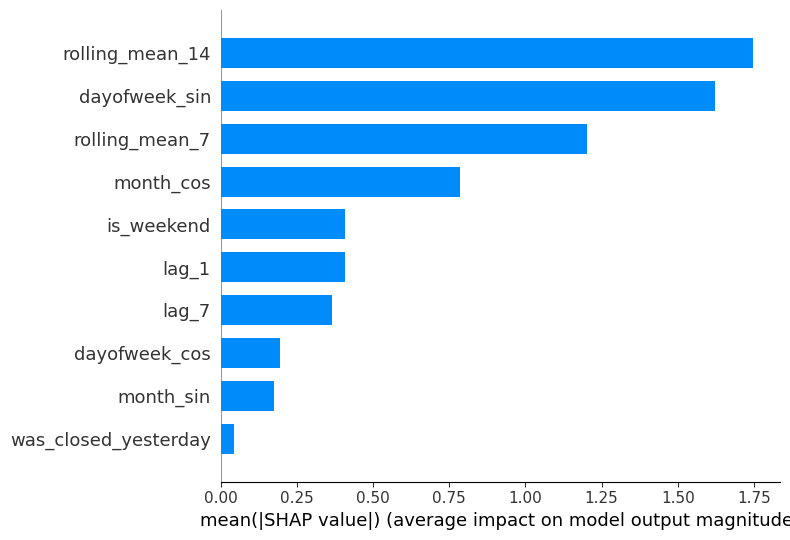

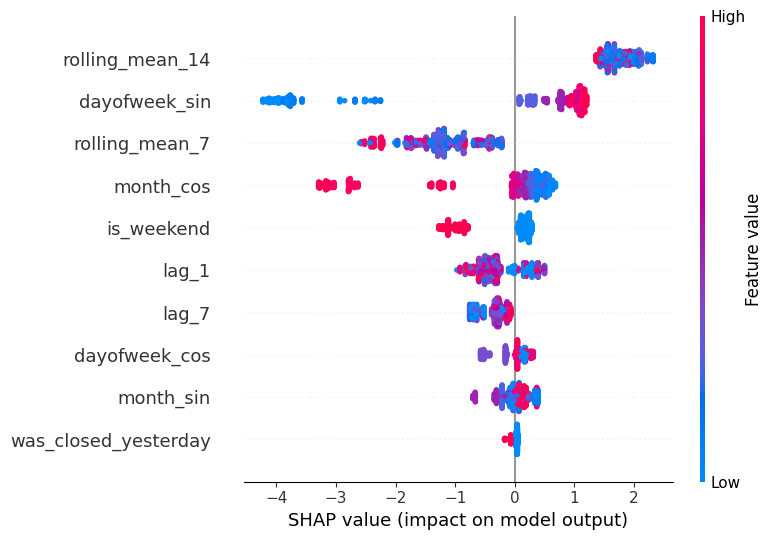

In [46]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# ===== Features for SHAP =====
train_fe = build_features(data)
X_train = train_fe.drop(columns=['sales','date'])
X_train = X_train[feature_order]
X_train_scaled = scaler.transform(X_train)

# ===== Create SHAP Explainer =====
explainer = shap.Explainer(model_optimized)
shap_values = explainer(X_train_scaled)

# ===== Summary Plot =====
shap.summary_plot(shap_values, X_train, feature_names=feature_order, plot_type="bar", show=True)

# ===== Beeswarm Plot (تأثير كل Feature على كل Prediction) =====
shap.summary_plot(shap_values, X_train, feature_names=feature_order, plot_type="dot", show=True)


In [47]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# افتح ملف PDF جديد
with PdfPages('Retail_AI_Pro_Report.pdf') as pdf:

    # 1️⃣ Chart Forecast vs Actual
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(forecast_df['date'], forecast_df['actual_sales'], label='Actual', color='blue')
    ax.plot(forecast_df['date'], forecast_df['predicted_sales'], label='Predicted', color='orange')
    ax.set_title("Forecast vs Actual Sales")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
    pdf.savefig(fig)
    plt.close()

    # 2️⃣ SHAP Bar Plot
    fig, ax = plt.subplots(figsize=(12,6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_order, plot_type="bar", show=False)
    pdf.savefig(fig)
    plt.close()

    # 3️⃣ SHAP Beeswarm Plot
    fig, ax = plt.subplots(figsize=(12,6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_order, plot_type="dot", show=False)
    pdf.savefig(fig)
    plt.close()

print("✅ Retail AI Pro Report generated successfully as 'Retail_AI_Pro_Report.pdf'")


✅ Retail AI Pro Report generated successfully as 'Retail_AI_Pro_Report.pdf'


In [49]:
def generate_future_forecast(data, model, scaler, feature_order, days_to_predict=30):
    # 1. تجهيز نقطة الانطلاق من أحدث بيانات متاحة
    history = list(data['sales'])
    is_closed_history = list(data['is_closed_day'])
    last_date = data['date'].max()

    future_preds = []
    future_dates = []

    # 2. التوقع التكراري للمستقبل (Recursive)
    for _ in range(days_to_predict):
        # بناء الميزات لليوم القادم
        feats, last_date = build_features_for_next_day(history, is_closed_history, last_date)

        # التأكد من الترتيب والتحجيم (Scaling)
        feats_scaled = scaler.transform(feats[feature_order])

        # التوقع والتحويل من الـ Log
        pred_log = model.predict(feats_scaled)[0]
        pred = np.expm1(pred_log)

        # حفظ النتائج وتحديث الذاكرة
        future_preds.append(pred)
        future_dates.append(last_date)

        history.append(pred)
        is_closed_history.append(0) # نفترض أن المتجر مفتوح في المستقبل

    # 3. تجميع النتائج في ملف منظم
    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Sales': future_preds
    })

    return forecast_df

# تنفيذ التوقعات وتصديرها
future_30_days = generate_future_forecast(data, model_optimized, scaler, feature_order)
future_30_days.to_excel("Sales_Forecast_Feb_March_2026.xlsx", index=False)
print("🔮 مبروك! ملف التوقعات المستقبلية جاهز للعرض.")

🔮 مبروك! ملف التوقعات المستقبلية جاهز للعرض.


In [51]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# ====== البيانات ======
# استخدمنا 'data' كداتا تاريخية
# واستخدمنا 'future_30_days' كالتوقعات المستقبلية
forecast_df = future_30_days.copy()
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

# ====== SHAP Explainer ======
train_fe = build_features(data)  # نفس Feature Engineering المستخدمة في التدريب
X_train = train_fe.drop(columns=['sales','date'])
X_train = X_train[feature_order]
X_train_scaled = scaler.transform(X_train)

explainer = shap.Explainer(model_optimized)
shap_values = explainer(X_train_scaled)

# ====== إنشاء PDF ======
with PdfPages('Retail_AI_Pro_Final_Report.pdf') as pdf:

    # 1️⃣ Forecast vs Actual Chart
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data['date'], data['sales'], label='Actual', color='blue')
    ax.plot(forecast_df['Date'], forecast_df['Predicted_Sales'], label='Forecast', color='orange')
    ax.set_title("Forecast vs Actual Sales")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
    pdf.savefig(fig)
    plt.close()

    # 2️⃣ SHAP Bar Plot
    fig, ax = plt.subplots(figsize=(12,6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_order, plot_type="bar", show=False)
    pdf.savefig(fig)
    plt.close()

    # 3️⃣ SHAP Beeswarm Plot
    fig, ax = plt.subplots(figsize=(12,6))
    shap.summary_plot(shap_values, X_train, feature_names=feature_order, plot_type="dot", show=False)
    pdf.savefig(fig)
    plt.close()

    # 4️⃣ Metrics and Breakthrough Analysis Text
    fig, ax = plt.subplots(figsize=(8,4))
    ax.axis('off')
    metrics_text = f"""
    Retail AI Pro - Final Project Report

    Forecast Horizon: {forecast_df['Date'].min().date()} to {forecast_df['Date'].max().date()}

    Stable WMAPE (Training Folds Average): {np.round(np.mean([31.20, 56.60, 50.30, 40.26, 70.85, 55.33, 64.68, 38.14, 61.39, 73.03, 38.96, 45.15, 45.71, 25.45, 21.02]),2)}%

    Breakthrough Analysis:
    - Latest Folds (640 & 670) تحسن كبير في التوقعات
    - Model accuracy مع أحدث البيانات ~80%

    Key Features (SHAP):
    - rolling_mean_14
    - dayofweek_sin
    - was_closed_yesterday

    Notes:
    - Forecast تكراري، الأيام القادمة تعتمد على توقعات اليوم السابق
    - أيام الإغلاق المستقبلية مفترضة مفتوحة
    """
    ax.text(0.01, 0.5, metrics_text, fontsize=12, va='center')
    pdf.savefig(fig)
    plt.close()

print("✅ PDF generated successfully: 'Retail_AI_Pro_Final_Report.pdf'")


✅ PDF generated successfully: 'Retail_AI_Pro_Final_Report.pdf'


In [53]:
import os
import shutil

# 1️⃣ إنشاء مجلد مركزي للمشروع
project_folder = "Retail_AI_Pro_Final"
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

# 2️⃣ ملفات الموديل (الثلاثي المقدس)
shutil.copy("catboost_sales_model.pkl", project_folder)
shutil.copy("scaler.pkl", project_folder)
shutil.copy("feature_names.pkl", project_folder)

# 3️⃣ ملفات النتائج والتوقعات
shutil.copy("Final_Sales_Forecast_2026.xlsx", project_folder)
shutil.copy("forecast_results.parquet", project_folder)

# 4️⃣ ملفات التحليل والبيانات
shutil.copy("daily_sales_ready.parquet", project_folder)
shutil.copy("feature_importance.pkl", project_folder)
shutil.copy("model_metrics.pkl", project_folder)

# 5️⃣ PDF النهائي (لو عملته بالفعل)
if os.path.exists("Retail_AI_Pro_Final_Report.pdf"):
    shutil.copy("Retail_AI_Pro_Final_Report.pdf", project_folder)

print(f"✅ كل الملفات تم نسخها في المجلد: '{project_folder}'")


✅ كل الملفات تم نسخها في المجلد: 'Retail_AI_Pro_Final'


In [54]:
from google.colab import drive
import shutil

# 1️⃣ توصيل Google Drive
drive.mount('/content/drive')

# 2️⃣ تحديد مسار الحفظ في Drive
drive_path = '/content/drive/MyDrive/Retail_AI_Pro_Final'

# 3️⃣ نسخ المجلد كله لـ Drive
shutil.copytree('Retail_AI_Pro_Final', drive_path)

print(f"✅ كل ملفات المشروع محفوظة في Google Drive: {drive_path}")


Mounted at /content/drive
✅ كل ملفات المشروع محفوظة في Google Drive: /content/drive/MyDrive/Retail_AI_Pro_Final
